In [1]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np

In [2]:
class World:
    def __init__(self):
        self.objects = []             # ここにロボットなどのオブジェクトを登録
        
    def append(self,obj):             # オブジェクトを登録するための関数
        self.objects.append(obj)
    
    def draw(self):
        fig = plt.figure(figsize=(4,4))                # 8x8 inchの図を準備
        ax = fig.add_subplot(111)                      # サブプロットを準備
        ax.set_aspect('equal')                         # 縦横比を座標の値と一致させる
        ax.set_xlim(-5,5)                              # X軸を-5m x 5mの範囲で描画
        ax.set_ylim(-5,5)                              # Y軸も同様に
        ax.set_title("$\Sigma_{world}$",fontsize=10)   # 図のタイトルをTeXの形式で埋め込み
        ax.set_xlabel("X",fontsize=10)                 # X軸にラベルを表示
        ax.set_ylabel("Y",fontsize=10)                 # 同じくY軸に
        
        elems = []
        self.ani = anm.FuncAnimation(fig, self.__one_step, fargs=(elems, ax),
                                     frames=100, interval=1000, repeat=False)

        plt.show()
        
    def __one_step(self, i, elems, ax):    ### fig:__one_step_add_one_step (1,24-29行目)
        while elems: elems.pop().remove()
        elems.append(ax.text(-4.4, 4.5, "t = "+str(i), fontsize=10)) 
        for obj in self.objects:
            obj.draw(ax, elems)
            obj.one_step(1.0)     # 追加

In [3]:
class IdealRobot:                         ### fig:rewrite_init_for_agent (1, 2, 6行目)
    def __init__(self, pose, agent=None, color="black"):  # agentという引数を追加
        self.pose = pose 
        self.r = 0.2 
        self.color = color 
        self.agent = agent      # 追加
        
    def vec_trans_to_world(self,vec):
        s = math.sin(self.pose[2])  # self.pose[2]はロボットの向き
        c = math.cos(self.pose[2])
        return np.array([[c, -s], 
                        [s, c]]).dot(vec) # 回転行列に引数のベクトルをかけて返す
    
    def pos_trans_to_world(self,pos):
        return self.vec_trans_to_world(pos) + self.pose[0:2]
    
    def draw(self, ax, elems):
        x, y, theta = self.pose                   # 姿勢の変数を分解して3つの変数へ
        xn = x + self.r * math.cos(theta)         #  ロボットの鼻先のx座標 
        yn = y + self.r * math.sin(theta)         #  ロボットの鼻先のy座標 
        elems += ax.plot([x,xn], [y,yn], color=self.color) # ロボットの向きを示す線分の描画
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color) 
        elems.append(ax.add_patch(c))   # 上のpatches.Circleでロボットの胴体を示す円を作ってサブプロットへ登録
    
       # self.draw_coordinate_system(ax)
         
    def draw_coordinate_system(self, ax):   
        origin = self.pos_trans_to_world(np.array([0, 0]).T) # ロボット座標系の原点を世界座標系へ
        for v in [[1, 0], [0, 1]]:                           # それぞれロボット座標系のX,Y軸の単位ベクトル
            wv = self.vec_trans_to_world(np.array(v).T)     # 世界座標系へ単位ベクトルを変換
            ax.quiver(origin[0], origin[1], wv[0], wv[1],  # 矢印で単位ベクトルを描画
                angles='xy', scale_units='xy', scale=1, color=self.color)
            
    def func_state_transition(self, nu, omega, time, pose):    ### fig:func_state_transition(1, 34-43行目)
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*math.cos(t0), 
                                     nu*math.sin(t0),
                                     omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time ] )

    def one_step(self, time_interval):            ### fig:robot_one_step
        if not self.agent: return
        nu, omega = self.agent.decision()
        self.pose = self.func_state_transition(nu, omega, time_interval, self.pose)

In [4]:
r = IdealRobot(0,0,0)                 ### fig:using_func_state_transition1
### 原点から0.1[m/s]で1[s]直進 ### 
p = r.func_state_transition(0.1, 0.0, 1.0, np.array([0,0,0]).T)
print(p) 

[ 0.1  0.   0. ]


In [5]:
### 原点から0.1[m/s], 10[deg/s]で9[s]移動 ###      ### fig:using_func_state_transition2
p = r.func_state_transition(0.1, 10.0/180*math.pi, 9.0, np.array([0,0,0]).T)
print(p) 
### 原点から0.1[m/s], 10[deg/s]で18[s]移動 ###
p = r.func_state_transition(0.1, 10.0/180*math.pi, 18.0, np.array([0,0,0]).T)
print(p) 

[ 0.5729578   0.5729578   1.57079633]
[  7.01670930e-17   1.14591559e+00   3.14159265e+00]


In [6]:
class Agent:                        ### fig:Agent
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega
        
    def decision(self):
        return self.nu, self.omega

<IPython.core.display.Javascript object>


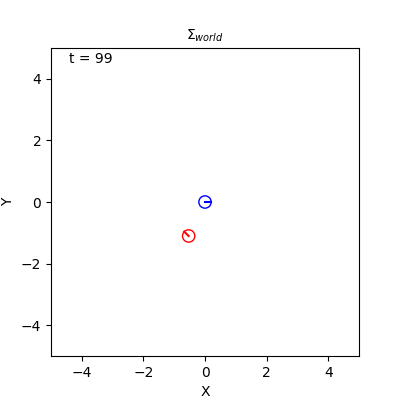

In [7]:
world = World()           ### fig:rewrite_robot_for_agent
straight = Agent(0.2, 0.0)                # 0.2[m/s]で直進     
circling = Agent(0.2, 10.0/180*math.pi)   # 0.2[m/s], 10[deg/s]（円を描く
robot1 = IdealRobot( np.array([ 2, 3, math.pi/6]).T,    straight )  
robot2 = IdealRobot( np.array([-2, -1, math.pi/5*6]).T, circling, "red")  
robot3 = IdealRobot( np.array([ 0, 0, 0]).T, color="blue")     # コントローラを与えないロボット
world.append(robot1)
world.append(robot2)
world.append(robot3)
world.draw()